In [ ]:
import numpy as np
import kagglehub
import os
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, Layer
from tensorflow.keras.models import Sequential
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
path = kagglehub.dataset_download("soumikrakshit/anime-faces")

100%|██████████| 441M/441M [00:06<00:00, 69.5MB/s]

Extracting files...


In [ ]:
INPUT_DIM = (64, 64, 3)
DATA_FOLDER = os.path.join(path, "data")

data_gen = ImageDataGenerator(rescale=1./255)

data_flow = data_gen.flow_from_directory(
    DATA_FOLDER,
    target_size=INPUT_DIM[:2],
    batch_size=64,
    shuffle=True,
    class_mode='input',
    subset='training'
)

Found 21551 images belonging to 1 classes.


In [ ]:
encoder_input = Input(shape = (64, 64, 3), name = 'encoder_input')
x = encoder_input
x = Conv2D(32, (3, 3), strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(64, (3, 3), strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(64, (3, 3), strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(64, (3, 3), strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = Flatten()(x)

mean_mu = Dense(128, name = 'mu')(x)
log_var = Dense(128, name = 'log_var')(x)

def sampling(args):
    mean_mu, log_var = args
    epsilon = tf.random.normal(shape=tf.shape(mean_mu), mean=0., stddev=1.)
    return mean_mu + tf.exp(log_var/2)*epsilon

encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])

encoder_model = Model(encoder_input, [encoder_output, mean_mu, log_var], name='encoder')

encoder_model.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │            896 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 32, 32, 32)     │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 16, 16, 64)     │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 64)       │         36,928 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 8, 8, 64)       │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 4, 4, 64)       │         36,928 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 4, 4, 64)       │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 1024)           │              0 │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mu (Dense)                │ (None, 128)            │        131,200 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ log_var (Dense)           │ (None, 128)            │        131,200 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_output (Lambda)   │ (None, 128)            │              0 │ mu[0][0],              │
│                           │                        │                │ log_var[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 355,648 (1.36 MB)

 Trainable params: 355,648 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
decoder_input = Input(shape = (128,) , name = 'decoder_input')
x = Dense(np.prod((4, 4, 64)))(decoder_input)
x = Reshape((4, 4, 64))(x)
x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(3, (3, 3), strides=2, padding='same')(x)
x = Activation('sigmoid')(x)
decoder_output = x

decoder_model = Model(decoder_input, decoder_output)

decoder_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         132,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 64, 64, 3)           │             867 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 64, 64, 3)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,283 (880.01 KB)

 Trainable params: 225,283 (880.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
vae_input = encoder_input
vae_latent, mean_mu, log_var = encoder_model(vae_input)
vae_output = decoder_model(vae_latent)

class KLLossLayer(Layer):
    def __init__(self, loss_factor=1.0, **kwargs):
        super(KLLossLayer, self).__init__(**kwargs)
        self.loss_factor = loss_factor

    def call(self, inputs):
        y_true, y_pred, mean_mu, log_var = inputs

        r_loss_value = tf.reduce_mean(tf.square(y_true - y_pred), axis=[1, 2, 3])

        kl_loss_value = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mean_mu) - tf.exp(log_var), axis=1)

        total_loss = self.loss_factor * r_loss_value + tf.reduce_mean(kl_loss_value)

        self.add_loss(total_loss)

        return y_pred

loss_factor = 1000
vae_output_with_loss = KLLossLayer(loss_factor=loss_factor)([vae_input, vae_output, mean_mu, log_var])

vae_model = Model(vae_input, vae_output_with_loss, name='vae')
vae_model.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder (Functional)      │ [(None, 128), (None,   │        355,648 │ encoder_input[0][0]    │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 64, 64, 3)      │        225,283 │ encoder[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ kl_loss_layer             │ (None, 64, 64, 3)      │              0 │ encoder_input[0][0],   │
│ (KLLossLayer)             │                        │                │ functional[0][0],      │
│                           │                        │                │ encoder[0][1],         │
│                           │                        │                │ encoder[0][2]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 580,931 (2.22 MB)

 Trainable params: 580,931 (2.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
vae_model.compile(optimizer='adam')

In [ ]:
vae_model.fit(data_flow,
              shuffle=True,
              epochs = 10,
              batch_size = 64,
              verbose=1)

Epoch 1/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 108s 320ms/step - loss: 3220.0740
Epoch 2/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 99s 291ms/step - loss: 3148.7058
Epoch 3/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 141s 289ms/step - loss: 3116.1958
Epoch 4/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 142s 290ms/step - loss: 3090.9963
Epoch 5/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 149s 311ms/step - loss: 3078.7068
Epoch 6/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 101s 298ms/step - loss: 3071.3977
Epoch 7/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 98s 291ms/step - loss: 3069.0618
Epoch 8/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 98s 290ms/step - loss: 3070.7268
Epoch 9/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 97s 288ms/step - loss: 3055.4451
Epoch 10/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 98s 291ms/step - loss: 3048.9399


In [ ]:
example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:10]

In [ ]:
def plot_compare_vae(images=None):

  if images is None:
      example_batch = next(data_flow)
      example_batch = example_batch[0]
      images = example_batch[:10]

  n_to_show = images.shape[0]
  reconst_images = vae_model.predict(images)

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


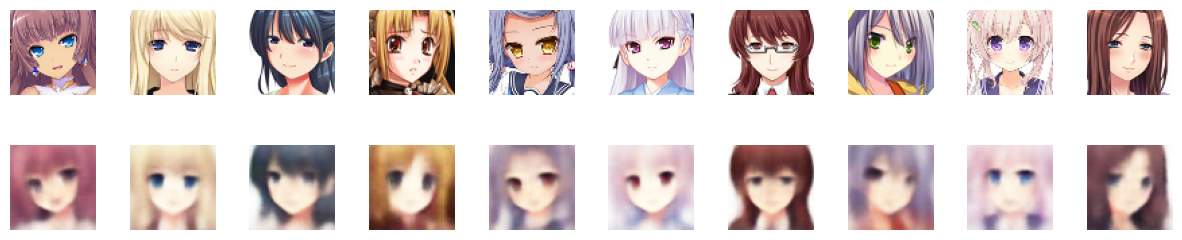

In [ ]:
plot_compare_vae(images = example_images)

In [ ]:
def vae_generate_images(n_to_show=10):
  reconst_images = decoder_model.predict(np.random.normal(0,1,size=(n_to_show,128)))

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')
        sub.imshow(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


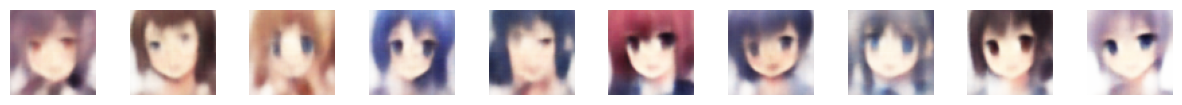

In [ ]:
vae_generate_images(n_to_show=10)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

def generate_gif_from_latent_interpolation(A, B, num_steps=30, gif_name="latent_interpolation.gif"):
    latent_A = encoder_model.predict(A[np.newaxis, ...])
    latent_B = encoder_model.predict(B[np.newaxis, ...])

    interpolated_latents = [latent_A * (1 - t) + latent_B * t for t in np.linspace(0, 1, num_steps)]

    generated_images = [decoder_model.predict(latent)[0] for latent in interpolated_latents]

    images_for_gif = []
    for img in generated_images:
        img_rescaled = (img - img.min()) / (img.max() - img.min())
        img_uint8 = (img_rescaled * 255).astype(np.uint8)

        if img_uint8.ndim == 2:
            images_for_gif.append(img_uint8)
        else:
            images_for_gif.append(img_uint8[..., :3])

    imageio.mimsave(gif_name, images_for_gif, fps=10)
    print(f"GIF: {gif_name}")

example_batch = next(data_flow)[0]
A = example_batch[0]
B = example_batch[1]

generate_gif_from_latent_interpolation(A, B)